# Imports and Settings

In [ ]:
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

In [ ]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [ ]:
sns.set_style('white')

In [ ]:
np.random.seed(42)
tf.random.set_seed(1234)

In [ ]:
path = Path('time_gan')
hdf_store = path / 'TimeSeriesGAN.h5'

# Load Data

In [ ]:
experiment = 0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
real_data_path = '/content/drive/MyDrive/BBG Capstone Summer 2023/Data/timegan_data_all.csv'

seq_len = 8
n_seq = 38

def get_real_data():
  df = pd.read_csv(real_data_path)
  df['Dates'] = pd.to_datetime(df['Unnamed: 1'], infer_datetime_format=True)
  df.set_index(zip(df['Unnamed: 0'], df['Dates']), inplace=True)
  df.drop(columns = ['Unnamed: 0','Unnamed: 1' ,'Dates', 'industry'], inplace = True)

  stocks = df.index.get_level_values(0).unique()
  n_stocks = len(stocks)
  total_timesteps = len(df.loc[stocks[0], :])
  features = len(df.columns)
  df_array = df.values.reshape((n_stocks, total_timesteps, features))


  scaler = MinMaxScaler()
  scaled_data = scaler.fit_transform(df)

  data = []
  for stock_arr in df_array:
    for i in range(len(stock_arr) - seq_len):
      data.append(scaled_data[i: i + seq_len])
  return data


real_data = get_real_data()

In [ ]:
n = len(real_data)

In [ ]:
np.asarray(real_data).shape

(4450, 8, 38)

In [ ]:
gen_data_path = '/content/drive/MyDrive/BBG Capstone Summer 2023/Runs/syn_data_1000_batches'

synthetic_data = np.load(gen_data_path + '/' + f'experiment_{experiment:02d}' + '/' + 'generated_data.npy')
synthetic_data.shape

(89000, 8, 38)

In [ ]:
real_data = real_data[:synthetic_data.shape[0]]

# Prepare Sample

In [ ]:
sample_size = 250
idx = np.random.permutation(len(real_data))[:sample_size]

In [ ]:
real_sample = np.asarray(real_data)[idx]
synthetic_sample = np.asarray(synthetic_data)[idx]

In [ ]:
real_sample_2d = real_sample.reshape(-1, seq_len)
synthetic_sample_2d = synthetic_sample.reshape(-1, seq_len)

In [ ]:
real_sample_2d.shape, synthetic_sample_2d.shape

((9500, 8), (9500, 8))

# Qualitative Assessment : Visualizaiton in 2-D


To visualize the real and synthetic series with 8 time steps and 38 features, we reduce their dimensionality so that we can plot them in two dimensions. To this end, we sample 250 normalized sequences with 38 features.

## PCA

PCA is a linear method that identifies a new basis with mutually orthogonal vectors that, successively, capture the directions of maximum variance in the data. We compute the first two components using the real data and then project both real and synthetic samples onto the new coordinate system:

In [ ]:
pca = PCA(n_components=2)
pca.fit(real_sample_2d)
pca_real = (pd.DataFrame(pca.transform(real_sample_2d))
            .assign(Data='Real'))
pca_synthetic = (pd.DataFrame(pca.transform(synthetic_sample_2d))
                 .assign(Data='Synthetic'))
pca_result = pca_real.append(pca_synthetic).rename(
    columns={0: '1st Component', 1: '2nd Component'})

<ipython-input-17-6d9674967aa6>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pca_result = pca_real.append(pca_synthetic).rename(


## t-SNE

t-SNE is a non-linear manifold learning method for the visualization of high-dimensional data. It converts similarities between data points to joint probabilities and aims to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. We compute t-SNE for the combined real and synthetic data as follows:

In [ ]:
tsne_data = np.concatenate((real_sample_2d,
                            synthetic_sample_2d), axis=0)

tsne = TSNE(n_components=2,
            verbose=1,
            perplexity=40)
tsne_result = tsne.fit_transform(tsne_data)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 19000 samples in 0.115s...
[t-SNE] Computed neighbors for 19000 samples in 1.924s...
[t-SNE] Computed conditional probabilities for sample 1000 / 19000
[t-SNE] Computed conditional probabilities for sample 2000 / 19000
[t-SNE] Computed conditional probabilities for sample 3000 / 19000
[t-SNE] Computed conditional probabilities for sample 4000 / 19000
[t-SNE] Computed conditional probabilities for sample 5000 / 19000
[t-SNE] Computed conditional probabilities for sample 6000 / 19000
[t-SNE] Computed conditional probabilities for sample 7000 / 19000
[t-SNE] Computed conditional probabilities for sample 8000 / 19000
[t-SNE] Computed conditional probabilities for sample 9000 / 19000
[t-SNE] Computed conditional probabilities for sample 10000 / 19000
[t-SNE] Computed conditional probabilities for sample 11000 / 19000
[t-SNE] Computed conditional probabilities for sample 12000 / 19000
[t-SNE] Computed conditional probabilities for sa

In [ ]:
tsne_result = pd.DataFrame(tsne_result, columns=['X', 'Y']).assign(Data='Real')
tsne_result.loc[sample_size*6:, 'Data'] = 'Synthetic'

## Plot Result

The below figure displays the PCA and t-SNE results for a qualitative assessment of the similarity of the real and synthetic data distributions.

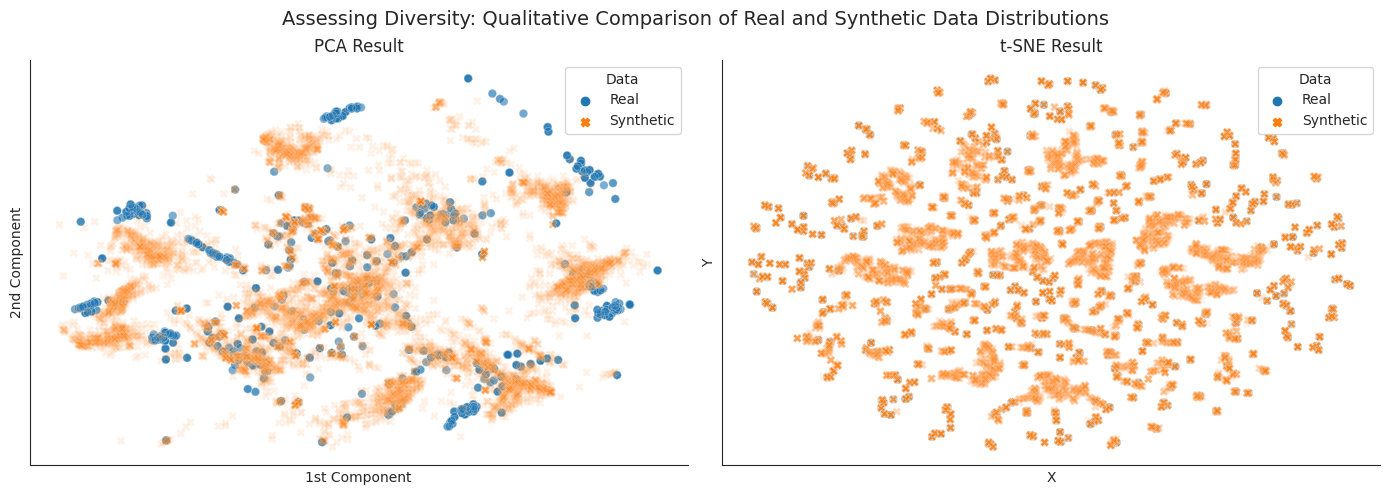

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))

sns.scatterplot(x='1st Component', y='2nd Component', data=pca_result,
                hue='Data', style='Data', ax=axes[0], alpha = 0.1)
sns.despine()
axes[0].set_title('PCA Result')


sns.scatterplot(x='X', y='Y',
                data=tsne_result,
                hue='Data',
                style='Data',
                ax=axes[1], alpha = 0.1)
sns.despine()
for i in [0, 1]:
    axes[i].set_xticks([])
    axes[i].set_yticks([])

axes[1].set_title('t-SNE Result')
fig.suptitle('Assessing Diversity: Qualitative Comparison of Real and Synthetic Data Distributions',
             fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.88);

# Quantitative Assessment

## Time-Series Classification

The visualization only provides a qualitative impression. For a quantitative assessment of the fidelity of the synthetic data, we train a time-series classifier to distinguish between real and fake data and evaluate its performance on a held-out test set.

More specifically, we select the first 80 percent of the rolling sequences for training, and the last 20 percent as test set as follows:

### Prepare Data

In [ ]:
real_data = get_real_data()
real_data = np.array(real_data)[:len(synthetic_data)]
real_data.shape

(4450, 8, 38)

In [ ]:
synthetic_data.shape

(89000, 8, 38)

In [ ]:
n_series = real_data.shape[0]

In [ ]:
idx = np.arange(n_series)

In [ ]:
n_train = int(.8*n_series)
train_idx = idx[:n_train]
test_idx = idx[n_train:]

In [ ]:
train_data = np.vstack((real_data[train_idx],
                        synthetic_data[train_idx]))
test_data = np.vstack((real_data[test_idx],
                       synthetic_data[test_idx]))

In [ ]:
n_train, n_test = len(train_idx), len(test_idx)
train_labels = np.concatenate((np.ones(n_train),
                               np.zeros(n_train)))
test_labels = np.concatenate((np.ones(n_test),
                              np.zeros(n_test)))

### Classifier

Then we create a simple RNN with six units that receives mini batches of real and synthetic series of shape 8 ⨉ 38 and uses a sigmoid activation. We optimize it using binary cross entropy loss and the Adam optimizer while tracking the AUC and accuracy metrics:

In [ ]:
ts_classifier = Sequential([GRU(6, input_shape=(8, 38), name='GRU'),
                            Dense(1, activation='sigmoid', name='OUT')],
                           name='Time_Series_Classifier')

In [ ]:
ts_classifier.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=[AUC(name='AUC'), 'accuracy'])

In [ ]:
ts_classifier.summary()

Model: "Time_Series_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 GRU (GRU)                   (None, 6)                 828       
                                                                 
 OUT (Dense)                 (None, 1)                 7         
                                                                 
Total params: 835
Trainable params: 835
Non-trainable params: 0
_________________________________________________________________


In [ ]:
result = ts_classifier.fit(x=train_data,
                           y=train_labels,
                           validation_data=(test_data, test_labels),
                           epochs=250,
                           batch_size=128,
                           verbose=0)

In [ ]:
ts_classifier.evaluate(x=test_data, y=test_labels)

56/56 [==============================] - 0s 3ms/step - loss: 2.9822e-06 - AUC: 1.0000 - accuracy: 1.0000


[2.9821605949109653e-06, 1.0, 1.0]

In [ ]:
history = pd.DataFrame(result.history)
history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   loss          250 non-null    float64
 1   AUC           250 non-null    float64
 2   accuracy      250 non-null    float64
 3   val_loss      250 non-null    float64
 4   val_AUC       250 non-null    float64
 5   val_accuracy  250 non-null    float64
dtypes: float64(6)
memory usage: 11.8 KB


### Plot Result

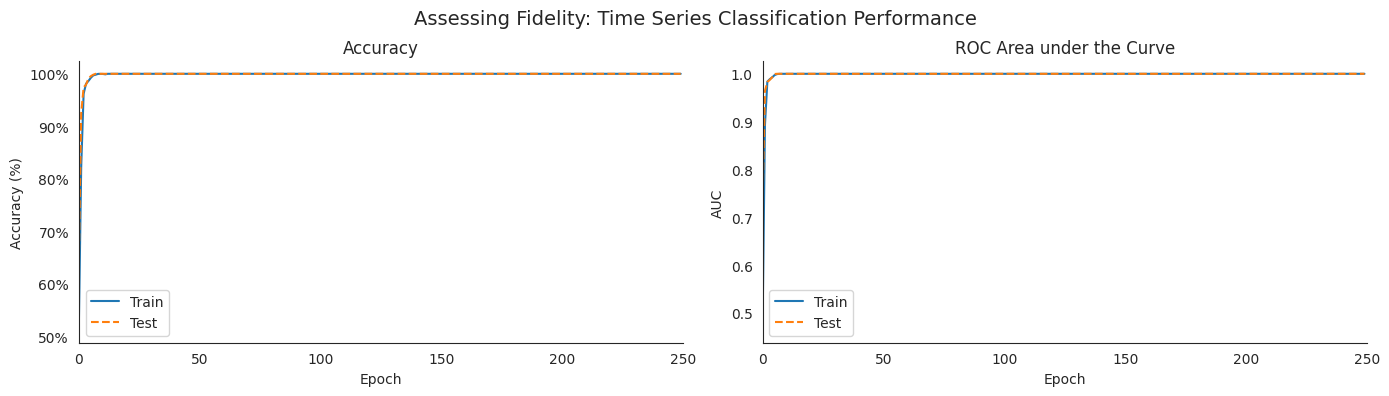

In [ ]:
sns.set_style('white')
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
history[['AUC', 'val_AUC']].rename(columns={'AUC': 'Train', 'val_AUC': 'Test'}).plot(ax=axes[1],
                                                                                     title='ROC Area under the Curve',
                                                                                    style=['-', '--'],
                                                                                    xlim=(0, 250))
history[['accuracy', 'val_accuracy']].rename(columns={'accuracy': 'Train', 'val_accuracy': 'Test'}).plot(ax=axes[0],
                                                                                                         title='Accuracy',
                                                                                                        style=['-', '--'],
                                                                                                        xlim=(0, 250))
for i in [0, 1]:
    axes[i].set_xlabel('Epoch')

axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
axes[0].set_ylabel('Accuracy (%)')
axes[1].set_ylabel('AUC')
sns.despine()
fig.suptitle('Assessing Fidelity: Time Series Classification Performance', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.85);

We observe that the classifier model is able to adequately distinguish between the real and synthetic data. This could be due to the small training batch used (250) and because of the fact that the synthetic data generated is unique to a specific industry which is not captured by the classifier.

## Time-Series Prediction

### Prepare Data

In [ ]:
real_data = get_real_data()
real_data = np.array(real_data)[:len(synthetic_data)]

In [ ]:
real_data.shape, synthetic_data.shape

((4450, 8, 38), (89000, 8, 38))

In [ ]:
real_train_data = real_data[train_idx, :7, :]
real_train_label = real_data[train_idx, -1, :]

real_test_data = real_data[test_idx, :7, :]
real_test_label = real_data[test_idx, -1, :]

In [ ]:
real_train_data.shape, real_train_label.shape, real_test_data.shape, real_test_label.shape

((3560, 7, 38), (3560, 38), (890, 7, 38), (890, 38))

In [ ]:
synthetic_train = synthetic_data[:, :7, :]
synthetic_label = synthetic_data[:, -1, :]

In [ ]:
synthetic_train.shape, synthetic_label.shape

((89000, 7, 38), (89000, 38))

We create a one-layer RNN with 12 GRU units that predicts the last time steps for the 26 financial features and, thus, has 38 linear output units. The model uses the Adam optimizer to minimize the mean absolute error (MAE):

In [ ]:
def get_model():
    model = Sequential([GRU(12,
                            input_shape=(seq_len-1,
                                         n_seq)),
                        Dense(38)])

    model.compile(optimizer=Adam(),
                  loss=MeanAbsoluteError(name='MAE'))
    return model

### Auto-regressive Prediction Model

We train the model twice using the synthetic and real data for training, respectively, and the real test set to evaluate the out-of-sample performance. Training on synthetic data works as follows, training on real data works analogously:

In [ ]:
ts_regression = get_model()
synthetic_result = ts_regression.fit(x=synthetic_train,
                                     y=synthetic_label,
                                     validation_data=(
                                         real_test_data,
                                         real_test_label),
                                     epochs=100,
                                     batch_size=128,
                                     verbose=0)

In [ ]:
synthetic_result = pd.DataFrame(synthetic_result.history).rename(columns={'loss': 'Train',
                                                                          'val_loss': 'Test'})

In [ ]:
ts_regression = get_model()
real_result = ts_regression.fit(x=real_train_data,
                                y=real_train_label,
                                validation_data=(
                                    real_test_data,
                                    real_test_label),
                                epochs=100,
                                batch_size=128,
                                verbose=0)

In [ ]:
real_result = pd.DataFrame(real_result.history).rename(columns={'loss': 'Train',
                                                                'val_loss': 'Test'})

### Plot Result


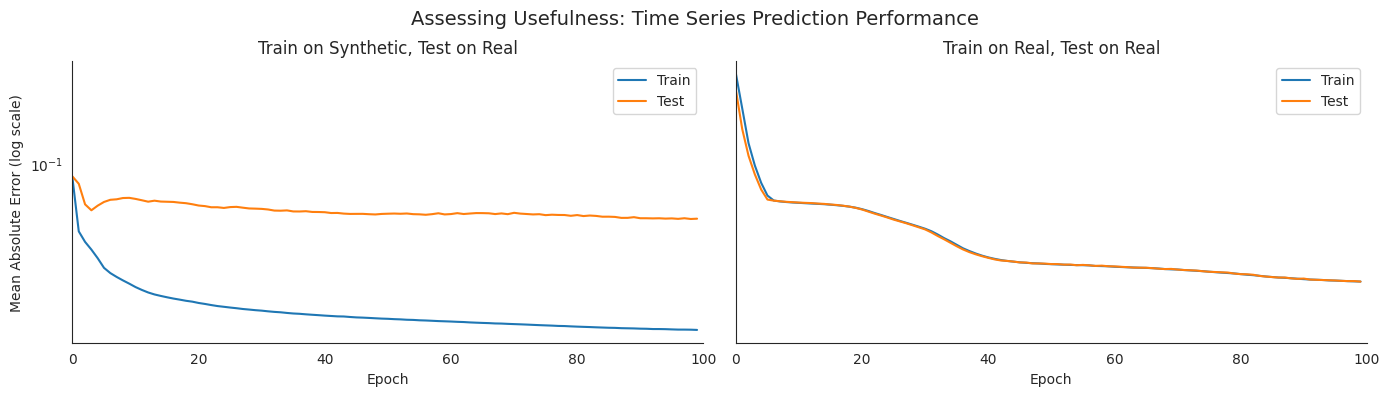

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4), sharey=True)

synthetic_result.plot(ax=axes[0], title='Train on Synthetic, Test on Real',
                      logy=True,
                      xlim=(0, 100))
real_result.plot(ax=axes[1], title='Train on Real, Test on Real',
                 logy=True,
                 xlim=(0, 100))

for i in [0, 1]:
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Mean Absolute Error (log scale)')

sns.despine()
fig.suptitle('Assessing Usefulness: Time Series Prediction Performance', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.85);

We observe that the auto-regressive prediction model trained on synthetic data fails to recreate the same performance on a real test set. However, when trained on the real data and tested on real data, we observe that the model overfits.

A possible explanation could be that the network model used is too shallow to adequately predict the high-dimensional output time-series, so we suggest expermenting with the model hyper-parameters to perform the test with different auto-regression model architectures.

# Future Work

We believe the proposed TimeGAN multivariate time-series generative model  framework, which captures both cross-sectional and temporal relationships to be better suited over traditional auto-regressive models for scenario analysis since we use a non-parametric probalistic model rather than interpolation/extrapolation used in an auto-regressive approach.

The next steps of our project would be to tune the model and training hyper-parameters of the autoencoder, supervisor, generator and discriminator networks in the TimeGAN network to optimize the parameters for our particular use case. Given the multi-phase training for TimeGAN, we were unable to adequately test for different combinations of hyper-parameters due to resource constraints and we relied on the parameters from the original TimeGAN paper.

Moreover, we also need to develop evaluation metrics specific to our use case for scenario analysis, instead of the generic ones listed above to ensure that the end user is adequately convinced that the generated synthetic data is appropriate and fulfills the necessary requirements. We propose working with prospective end-users of this framework to collaborate and understand how best to develop such evalution criteria.